<a href="https://colab.research.google.com/github/sidharth178/Face-Mask-Detection-and-Alert-System/blob/master/face_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align ="center"><b>=========== Face Mask Scanner ===========</h1>

# **Table of Contents**

1. Introduction
1. Fetch datasets from kaggle
1. Load Dataset
1. Import library
1. Data Augmentation
1. Model Building
1. Model Fitting
1. Training Loss & Accuracy Visualization
1. Find prediction



# **Introduction**
### **Objective**
The objective of this project is to detect the presence of a face mask on human faces on live streaming video as well as on images and alert the authority to take action on those who'r not wearing mask.
### **Dataset**
Click [here](https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset) .



# **1. Fetch datasets from kaggle**

In [ ]:
# Step-1: create .kaggle directory
!mkdir ~/.kaggle

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Step-4: Download datasets from kaggle using API
# !kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
!kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/prithwirajmitra/covid-face-mask-detection-dataset
License(s): copyright-authors


# **2. Load Dataset**

In [ ]:
# unzip the dataset
from zipfile import ZipFile
zf = ZipFile('/content/covid-face-mask-detection-dataset.zip')
zf.extractall('/content/sample_data') #save files in selected folder
zf.close()

# **3. Import Libraries**

In [ ]:
import os
import cv2
import numpy as np
import random
import keras
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (Input, AveragePooling2D, Dropout,
                                     BatchNormalization, MaxPooling2D,
                                     Flatten, Dense)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report


In [ ]:
from zipfile import ZipFile

# Load the zip again to keep zf context
zf = ZipFile('/content/covid-face-mask-detection-dataset.zip')

# Get list of all files
file_list = zf.namelist()
print("Total files in zip:", len(file_list))

# Preview top and bottom (head & tail)
print("\n📄 Head:")
print("\n".join(file_list[:5]))

print("\n📄 Tail:")
print("\n".join(file_list[-5:]))


Total files in zip: 1006

📄 Head:
New Masks Dataset/Test/Mask/2070.jpg
New Masks Dataset/Test/Mask/2072.jpg
New Masks Dataset/Test/Mask/2083.jpg
New Masks Dataset/Test/Mask/2085.jpg
New Masks Dataset/Test/Mask/2086.jpg

📄 Tail:
New Masks Dataset/Validation/Non Mask/real_01027.jpg
New Masks Dataset/Validation/Non Mask/real_01028.jpg
New Masks Dataset/Validation/Non Mask/real_01029.jpg
New Masks Dataset/Validation/Non Mask/real_01030.jpg
New Masks Dataset/Validation/Non Mask/real_01031.jpg


In [ ]:
from collections import defaultdict

class_counts = defaultdict(int)

for f in image_files:
    parts = f.split('/')
    if len(parts) > 1:
        label = parts[-2]
        class_counts[label] += 1

print("Images per class:")
for label, count in class_counts.items():
    print(f"{label:20}: {count}")


Images per class:
Mask                : 494
Non Mask            : 503


Display sample images from zip

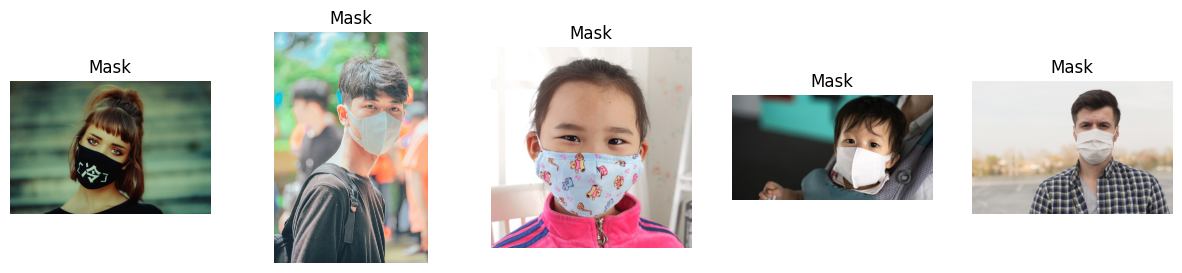

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import io

def show_images_from_zip(zf, file_list, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        file = file_list[i]
        data = zf.read(file)
        img = Image.open(io.BytesIO(data)).convert("RGB")
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(file.split('/')[-2])
        plt.axis('off')
    plt.show()

show_images_from_zip(zf, image_files)


In [ ]:
image_shapes = []

for f in image_files[:200]:  # sample 200 images
    data = zf.read(f)
    try:
        img = Image.open(io.BytesIO(data)).convert("RGB")
        image_shapes.append(img.size)  # (width, height)
    except:
        continue

# Analyze dimensions
import numpy as np
widths, heights = zip(*image_shapes)
print("Avg Width:", np.mean(widths))
print("Avg Height:", np.mean(heights))
print("Min Width:", min(widths), "Max Width:", max(widths))
print("Min Height:", min(heights), "Max Height:", max(heights))


Avg Width: 804.35
Avg Height: 699.33
Min Width: 400 Max Width: 3000
Min Height: 345 Max Height: 4256


# **4. Sample Image**
### **With Mask**

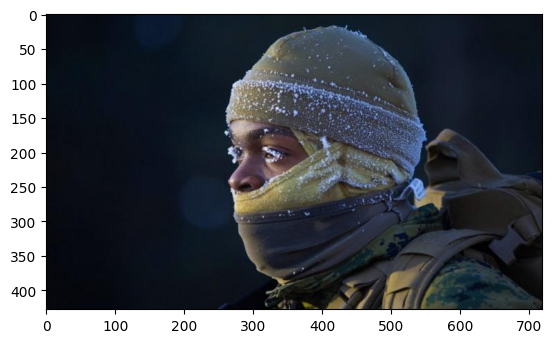

In [ ]:
images_withMask = os.listdir("/content/sample_data/New Masks Dataset/Train/Mask")
sample_img_withMask = random.choice(images_withMask)
image = load_img("/content/sample_data/New Masks Dataset/Train/Mask/"+sample_img_withMask)
plt.imshow(image)

### **Without Mask**

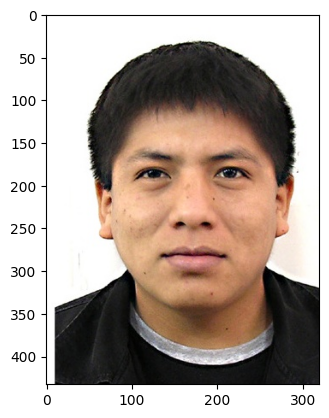

In [ ]:
images_withoutMask = os.listdir("/content/sample_data/New Masks Dataset/Train/Non Mask")
sample_img_withoutMask = random.choice(images_withoutMask)
image = load_img("/content/sample_data/New Masks Dataset/Train/Non Mask/"+sample_img_withoutMask)
plt.imshow(image)

# **5. Data Augmentation**

In [ ]:
# define constant
img_width=224
img_height=224

# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 50
BS = 32
train_data_dir="/content/sample_data/New Masks Dataset/Train"
test_data_dir="/content/sample_data/New Masks Dataset/Validation"

In [ ]:
all_train_imagePaths = list(paths.list_images(train_data_dir))
all_test_imagePaths = list(paths.list_images(test_data_dir))
train_data = []
train_labels = []
test_data = []
test_labels = []

In [ ]:
# loop over the image paths
for imagePath in all_train_imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	train_data.append(image)
	train_labels.append(label)

In [ ]:
# loop over the image paths
for imagePath in all_test_imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))

	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	test_data.append(image)
	test_labels.append(label)

In [ ]:
def convert_data_labels(data,labels):
  # convert the data and labels to NumPy arrays
  data = np.array(data, dtype="float32")
  labels = np.array(labels)

  # perform one-hot encoding on the labels
  lb = LabelBinarizer()
  labels = lb.fit_transform(labels)
  labels = to_categorical(labels)
  return  data,labels

In [ ]:
train_data,train_labels = convert_data_labels(train_data,train_labels)
test_data,test_labels = convert_data_labels(test_data,test_labels)

In [ ]:
print("==================================")
print("Size of train dataset : ",train_data.shape[0])
print("==================================")
print("Size of test dataset : ",test_data.shape[0])
print("==================================")

Size of train dataset :  600
Size of test dataset :  306


In [ ]:
# train datagen
train_datagen = ImageDataGenerator(
                  rotation_range=20,
                  zoom_range=0.15,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  shear_range=0.15,
                  horizontal_flip=True,
                  fill_mode="nearest")

train_generator = train_datagen.flow(train_data, train_labels, batch_size=BS)

# **6. Model Building**

### **6.1. Load MobileNetV2**

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

<ipython-input-30-c633dfd5e8ac>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# construct the head of the model that will be placed on top of the the base model
headModel = mobilenet.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=mobilenet.input, outputs=headModel)

In [ ]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("Done !!")


[INFO] compiling model...
Done !!


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in mobilenet.layers:
	layer.trainable = False

In [ ]:
# this code is to show how much time required to train the model using different algorithms
from datetime import datetime
def timer(start_time= None):
  if not start_time:
    start_time=datetime.now()
    return start_time
  elif start_time:
    thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
    tmin,tsec=divmod(temp_sec,60)
    print('\n Time taken: %i hours %i minutes and %s seconds. '% (thour,tmin,round(tsec,2)))

### **6.2. Callback Function**

In [ ]:
# checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
# # history=model.fit(train_data,train_target,epochs=100,callbacks=[checkpoint],validation_split=0.2)
# EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

# ModelCheckPoint
checkPoint = keras.callbacks.ModelCheckpoint(filepath="/content/sample_data/fmd_model.h5",
                             monitor='val_loss',
                             mode='auto',
                             save_best_only=True,
                             verbose=1)

# ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

# TBoard = tf.keras.callbacks.TensorBoard(log_dir='./logs')

In [ ]:
callbacks = [earlystop , checkPoint, learning_rate_reduction]

# **7. Model Fitting**

In [ ]:
start_time=timer(None)
classifier = model.fit(
    train_datagen.flow(train_data, train_labels, batch_size=BS),
    epochs=EPOCHS,
    validation_data=(test_data,test_labels),
    validation_steps=len(test_data)//BS,
    steps_per_epoch=len(train_data)//BS,
    callbacks=callbacks
)
timer(start_time)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.5037 - loss: 0.8138

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(34, 224, 224, 3))
  warnings.warn(msg)



Epoch 1: val_loss improved from inf to 0.50187, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5079 - loss: 0.8096 - val_accuracy: 0.8889 - val_loss: 0.5019 - learning_rate: 1.0000e-04
Epoch 2/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6875 - loss: 0.5874

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.50187 to 0.49167, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6875 - loss: 0.5874 - val_accuracy: 0.8889 - val_loss: 0.4917 - learning_rate: 1.0000e-04
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.8176 - loss: 0.5138
Epoch 3: val_loss improved from 0.49167 to 0.34643, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - accuracy: 0.8192 - loss: 0.5120 - val_accuracy: 0.9608 - val_loss: 0.3464 - learning_rate: 1.0000e-04
Epoch 4/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9062 - loss: 0.4216
Epoch 4: val_loss improved from 0.34643 to 0.34011, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9062 - loss: 0.4216 - val_accuracy: 0.9641 - val_loss: 0.3401 - learning_rate: 1.0000e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9087 - loss: 0.3650
Epoch 5: val_loss improved from 0.34011 to 0.25023, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 400ms/step - accuracy: 0.9095 - loss: 0.3640 - val_accuracy: 0.9739 - val_loss: 0.2502 - learning_rate: 1.0000e-04
Epoch 6/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9688 - loss: 0.2727
Epoch 6: val_loss improved from 0.25023 to 0.24609, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9688 - loss: 0.2727 - val_accuracy: 0.9739 - val_loss: 0.2461 - learning_rate: 1.0000e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9149 - loss: 0.2985
Epoch 7: val_loss improved from 0.24609 to 0.18866, saving model to /content/sample_data/fmd_model.h5



Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 437ms/step - accuracy: 0.9161 - loss: 0.2969 - val_accuracy: 0.9739 - val_loss: 0.1887 - learning_rate: 1.0000e-04
Epoch 8/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.1858
Epoch 8: val_loss improved from 0.18866 to 0.18742, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.1858 - val_accuracy: 0.9739 - val_loss: 0.1874 - learning_rate: 5.0000e-05
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9472 - loss: 0.2210
Epoch 9: val_loss improved from 0.18742 to 0.16710, saving model to /content/sample_data/fmd_model.h5



Epoch 9: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 379ms/step - accuracy: 0.9476 - loss: 0.2205 - val_accuracy: 0.9739 - val_loss: 0.1671 - learning_rate: 5.0000e-05
Epoch 10/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.1563
Epoch 10: val_loss improved from 0.16710 to 0.16662, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.1563 - val_accuracy: 0.9739 - val_loss: 0.1666 - learning_rate: 2.5000e-05
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9740 - loss: 0.1776
Epoch 11: val_loss improved from 0.16662 to 0.15823, saving model to /content/sample_data/fmd_model.h5



Epoch 11: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 385ms/step - accuracy: 0.9733 - loss: 0.1780 - val_accuracy: 0.9739 - val_loss: 0.1582 - learning_rate: 2.5000e-05
Epoch 12/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9688 - loss: 0.1296
Epoch 12: val_loss improved from 0.15823 to 0.15801, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9688 - loss: 0.1296 - val_accuracy: 0.9739 - val_loss: 0.1580 - learning_rate: 1.2500e-05
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9629 - loss: 0.2102
Epoch 13: val_loss improved from 0.15801 to 0.15448, saving model to /content/sample_data/fmd_model.h5



Epoch 13: ReduceLROnPlateau reducing learning rate to 1e-05.
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 392ms/step - accuracy: 0.9631 - loss: 0.2095 - val_accuracy: 0.9739 - val_loss: 0.1545 - learning_rate: 1.2500e-05
Epoch 14/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9688 - loss: 0.1895
Epoch 14: val_loss improved from 0.15448 to 0.15433, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9688 - loss: 0.1895 - val_accuracy: 0.9739 - val_loss: 0.1543 - learning_rate: 1.0000e-05
Epoch 15/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9541 - loss: 0.2050
Epoch 15: val_loss improved from 0.15433 to 0.15174, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 386ms/step - accuracy: 0.9544 - loss: 0.2044 - val_accuracy: 0.9739 - val_loss: 0.1517 - learning_rate: 1.0000e-05
Epoch 16/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.1532
Epoch 16: val_loss improved from 0.15174 to 0.15159, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 1.0000 - loss: 0.1532 - val_accuracy: 0.9739 - val_loss: 0.1516 - learning_rate: 1.0000e-05
Epoch 17/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9655 - loss: 0.1748
Epoch 17: val_loss improved from 0.15159 to 0.14896, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 452ms/step - accuracy: 0.9653 - loss: 0.1753 - val_accuracy: 0.9739 - val_loss: 0.1490 - learning_rate: 1.0000e-05
Epoch 18/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9688 - loss: 0.1627
Epoch 18: val_loss improved from 0.14896 to 0.14881, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9688 - loss: 0.1627 - val_accuracy: 0.9739 - val_loss: 0.1488 - learning_rate: 1.0000e-05
Epoch 19/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9725 - loss: 0.1627
Epoch 19: val_loss improved from 0.14881 to 0.14629, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 449ms/step - accuracy: 0.9724 - loss: 0.1632 - val_accuracy: 0.9739 - val_loss: 0.1463 - learning_rate: 1.0000e-05
Epoch 20/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.1258
Epoch 20: val_loss improved from 0.14629 to 0.14614, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 1.0000 - loss: 0.1258 - val_accuracy: 0.9739 - val_loss: 0.1461 - learning_rate: 1.0000e-05
Epoch 21/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9732 - loss: 0.1635
Epoch 21: val_loss improved from 0.14614 to 0.14348, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - accuracy: 0.9735 - loss: 0.1635 - val_accuracy: 0.9739 - val_loss: 0.1435 - learning_rate: 1.0000e-05
Epoch 22/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.1157
Epoch 22: val_loss improved from 0.14348 to 0.14334, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 1.0000 - loss: 0.1157 - val_accuracy: 0.9739 - val_loss: 0.1433 - learning_rate: 1.0000e-05
Epoch 23/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9619 - loss: 0.1766
Epoch 23: val_loss improved from 0.14334 to 0.14084, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 443ms/step - accuracy: 0.9622 - loss: 0.1759 - val_accuracy: 0.9706 - val_loss: 0.1408 - learning_rate: 1.0000e-05
Epoch 24/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.1206
Epoch 24: val_loss improved from 0.14084 to 0.14070, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 1.0000 - loss: 0.1206 - val_accuracy: 0.9706 - val_loss: 0.1407 - learning_rate: 1.0000e-05
Epoch 25/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9679 - loss: 0.1679
Epoch 25: val_loss improved from 0.14070 to 0.13819, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 445ms/step - accuracy: 0.9679 - loss: 0.1680 - val_accuracy: 0.9706 - val_loss: 0.1382 - learning_rate: 1.0000e-05
Epoch 26/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9375 - loss: 0.2045
Epoch 26: val_loss improved from 0.13819 to 0.13807, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9375 - loss: 0.2045 - val_accuracy: 0.9706 - val_loss: 0.1381 - learning_rate: 1.0000e-05
Epoch 27/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9575 - loss: 0.1713
Epoch 27: val_loss improved from 0.13807 to 0.13609, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 444ms/step - accuracy: 0.9578 - loss: 0.1710 - val_accuracy: 0.9706 - val_loss: 0.1361 - learning_rate: 1.0000e-05
Epoch 28/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9688 - loss: 0.1340
Epoch 28: val_loss improved from 0.13609 to 0.13599, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9688 - loss: 0.1340 - val_accuracy: 0.9706 - val_loss: 0.1360 - learning_rate: 1.0000e-05
Epoch 29/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9622 - loss: 0.1656
Epoch 29: val_loss improved from 0.13599 to 0.13399, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 379ms/step - accuracy: 0.9624 - loss: 0.1655 - val_accuracy: 0.9706 - val_loss: 0.1340 - learning_rate: 1.0000e-05
Epoch 30/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0943
Epoch 30: val_loss improved from 0.13399 to 0.13389, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 1.0000 - loss: 0.0943 - val_accuracy: 0.9706 - val_loss: 0.1339 - learning_rate: 1.0000e-05
Epoch 31/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9694 - loss: 0.1437
Epoch 31: val_loss improved from 0.13389 to 0.13162, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 437ms/step - accuracy: 0.9693 - loss: 0.1444 - val_accuracy: 0.9706 - val_loss: 0.1316 - learning_rate: 1.0000e-05
Epoch 32/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0846
Epoch 32: val_loss improved from 0.13162 to 0.13152, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 1.0000 - loss: 0.0846 - val_accuracy: 0.9706 - val_loss: 0.1315 - learning_rate: 1.0000e-05
Epoch 33/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9698 - loss: 0.1507
Epoch 33: val_loss improved from 0.13152 to 0.12932, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 460ms/step - accuracy: 0.9696 - loss: 0.1512 - val_accuracy: 0.9706 - val_loss: 0.1293 - learning_rate: 1.0000e-05
Epoch 34/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.1377
Epoch 34: val_loss improved from 0.12932 to 0.12920, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.1377 - val_accuracy: 0.9706 - val_loss: 0.1292 - learning_rate: 1.0000e-05
Epoch 35/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9786 - loss: 0.1490
Epoch 35: val_loss improved from 0.12920 to 0.12717, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 399ms/step - accuracy: 0.9787 - loss: 0.1491 - val_accuracy: 0.9706 - val_loss: 0.1272 - learning_rate: 1.0000e-05
Epoch 36/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9688 - loss: 0.1650
Epoch 36: val_loss improved from 0.12717 to 0.12708, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9688 - loss: 0.1650 - val_accuracy: 0.9706 - val_loss: 0.1271 - learning_rate: 1.0000e-05
Epoch 37/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9818 - loss: 0.1299
Epoch 37: val_loss improved from 0.12708 to 0.12529, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - accuracy: 0.9817 - loss: 0.1304 - val_accuracy: 0.9706 - val_loss: 0.1253 - learning_rate: 1.0000e-05
Epoch 38/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9375 - loss: 0.1581
Epoch 38: val_loss improved from 0.12529 to 0.12518, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9375 - loss: 0.1581 - val_accuracy: 0.9706 - val_loss: 0.1252 - learning_rate: 1.0000e-05
Epoch 39/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9725 - loss: 0.1384
Epoch 39: val_loss improved from 0.12518 to 0.12358, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 454ms/step - accuracy: 0.9730 - loss: 0.1378 - val_accuracy: 0.9706 - val_loss: 0.1236 - learning_rate: 1.0000e-05
Epoch 40/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9062 - loss: 0.1931
Epoch 40: val_loss improved from 0.12358 to 0.12348, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9062 - loss: 0.1931 - val_accuracy: 0.9706 - val_loss: 0.1235 - learning_rate: 1.0000e-05
Epoch 41/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9697 - loss: 0.1388
Epoch 41: val_loss improved from 0.12348 to 0.12162, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 410ms/step - accuracy: 0.9698 - loss: 0.1388 - val_accuracy: 0.9739 - val_loss: 0.1216 - learning_rate: 1.0000e-05
Epoch 42/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 0.0896
Epoch 42: val_loss improved from 0.12162 to 0.12153, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0896 - val_accuracy: 0.9739 - val_loss: 0.1215 - learning_rate: 1.0000e-05
Epoch 43/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9656 - loss: 0.1417
Epoch 43: val_loss improved from 0.12153 to 0.11969, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step - accuracy: 0.9661 - loss: 0.1415 - val_accuracy: 0.9739 - val_loss: 0.1197 - learning_rate: 1.0000e-05
Epoch 44/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9062 - loss: 0.2691
Epoch 44: val_loss improved from 0.11969 to 0.11958, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9062 - loss: 0.2691 - val_accuracy: 0.9739 - val_loss: 0.1196 - learning_rate: 1.0000e-05
Epoch 45/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9823 - loss: 0.1285
Epoch 45: val_loss improved from 0.11958 to 0.11792, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 408ms/step - accuracy: 0.9822 - loss: 0.1286 - val_accuracy: 0.9739 - val_loss: 0.1179 - learning_rate: 1.0000e-05
Epoch 46/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.1348
Epoch 46: val_loss improved from 0.11792 to 0.11783, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 1.0000 - loss: 0.1348 - val_accuracy: 0.9739 - val_loss: 0.1178 - learning_rate: 1.0000e-05
Epoch 47/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.9757 - loss: 0.1284
Epoch 47: val_loss improved from 0.11783 to 0.11620, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step - accuracy: 0.9759 - loss: 0.1285 - val_accuracy: 0.9739 - val_loss: 0.1162 - learning_rate: 1.0000e-05
Epoch 48/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 0.0985
Epoch 48: val_loss improved from 0.11620 to 0.11614, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 1.0000 - loss: 0.0985 - val_accuracy: 0.9739 - val_loss: 0.1161 - learning_rate: 1.0000e-05
Epoch 49/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9581 - loss: 0.1276
Epoch 49: val_loss improved from 0.11614 to 0.11467, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 451ms/step - accuracy: 0.9585 - loss: 0.1279 - val_accuracy: 0.9739 - val_loss: 0.1147 - learning_rate: 1.0000e-05
Epoch 50/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9688 - loss: 0.1427
Epoch 50: val_loss improved from 0.11467 to 0.11460, saving model to /content/sample_data/fmd_model.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9688 - loss: 0.1427 - val_accuracy: 0.9739 - val_loss: 0.1146 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 50.

 Time taken: 0 hours 4 minutes and 11.35 seconds. 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/face_mask_model.h5'
model.save(model_path)
print(f"✅ Model saved at: {model_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved at: /content/drive/MyDrive/face_mask_model.h5


# **8. Training Loss and Accuracy Visualization**

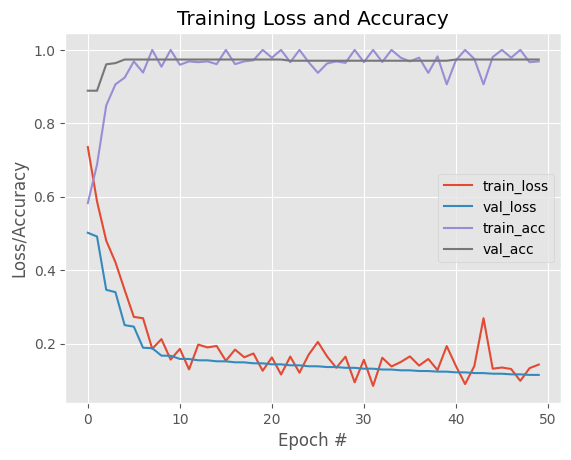

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
N = 10 # epochs number
plt.figure()
plt.plot( classifier.history["loss"], label="train_loss")
plt.plot( classifier.history["val_loss"], label="val_loss")
plt.plot( classifier.history["accuracy"], label="train_acc")
plt.plot( classifier.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")

### **8.1. Find Prediction**

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(test_data, batch_size=BS)

[INFO] evaluating network...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 577ms/step


In [ ]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

### **8.2. Find Accuracy**

In [ ]:
# check accuracy
val_loss,val_acc = model.evaluate(test_data,test_labels)
print("=======================================================")
print("Accuracy is : ",val_acc)
print("=======================================================")
print("Loss is : ",val_loss)
print("=======================================================")

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.9729 - loss: 0.1060
Accuracy is :  0.9738562107086182
Loss is :  0.1146039366722107


### **8.3. Classification Report**

In [ ]:
# show a nicely formatted classification report
print(classification_report(test_labels.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       153
           1       0.98      0.97      0.97       153

    accuracy                           0.97       306
   macro avg       0.97      0.97      0.97       306
weighted avg       0.97      0.97      0.97       306



In [ ]:
# Mount Drive & Save
from google.colab import drive
drive.mount('/content/drive')

model_path = '/content/drive/MyDrive/face_mask_model.h5'
model.save(model_path)
print(f"✅ Model saved at: {model_path}")


Mounted at /content/drive
✅ Model saved at: /content/drive/MyDrive/face_mask_model.h5
